# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd

from scipy.special import erf, erfinv

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from scipy.interpolate import interp1d

import math

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Data Generation

### Data Gen Function (Goldberg)

In [2]:
def generate_data(N):

    x = torch.tensor(np.random.rand(N))  # Uniformly distributed random numbers between 0 and 1
    x[0] = 0  # Ensure the first element is 0
    x[-1] = 1  # Ensure the last element is 1

    # Define the nonlinear function
    nonlin_f = lambda x: 2 * torch.sin(2 * torch.pi * x)
    y = nonlin_f(x)

    # True standard deviation as a function of x, TRUE SIGMA - function of the inputs x
    std_true = x + 0.5

    # Generate random noise with standard deviation dependent on x
    d = torch.Tensor(torch.randn(N) * std_true)  # ERROR

    # Compute the true output with noise
    t_true = torch.Tensor(nonlin_f(x) + d)

    return x, t_true, nonlin_f, d, std_true, y


### Data Gen Function #2 (MultiD)

In [3]:
def oscil(xx, u=None, a=None):
    xx = torch.tensor(xx, dtype=torch.float32)
    d = xx.shape[0]
    
    if u is None:
        u = torch.full((d,), 0.5, dtype=torch.float32)
    else:
        u = torch.tensor(u, dtype=torch.float32)
    
    if a is None:
        a = torch.full((d,), 5.0, dtype=torch.float32)
    else:
        a = torch.tensor(a, dtype=torch.float32)
    
    term1 = 2 * np.pi * u[0]
    sum_term = torch.sum(a * xx)
    
    y = 0.45 * (torch.cos(term1 + sum_term) + 1.2)
    return y


def generate_multi_data(N, D):
    x = torch.rand(N, D)  # Batch-first convention

    # Compute std_true: shape [N]
    # (Vectorized version of oscil)
    a = torch.full((D,), 5.0)
    term1 = 2 * np.pi * 0.5  # Fixed u[0] = 0.5
    sum_term = x @ a  # Matrix multiply [N, D] @ [D] → [N]
    std_true = 0.45 * (torch.cos(term1 + sum_term) + 1.2)

    # Generate residuals d: shape [N]
    d = torch.randn(N) * std_true

    return x, d, d, std_true


### Data Gen 

#### Univariate

In [4]:
N = 200
x, t_true, nonlin_f, d, std_true, y = generate_data(N)

#### Multivariate

In [5]:
N = 200
D = 5
x, t_true, d, std_true = generate_multi_data(N, D)

### Initial Plots

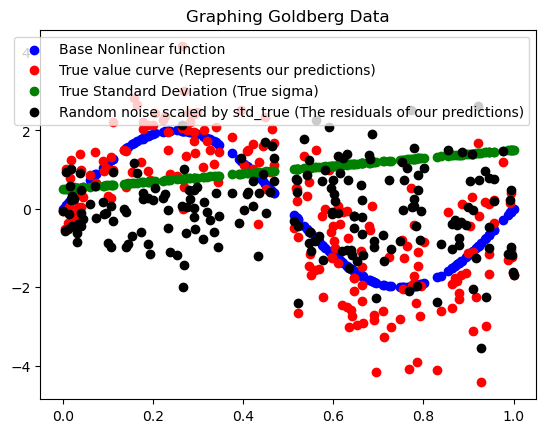

In [240]:
plt.figure()
plt.scatter(x, y, color = 'blue', label = 'Base Nonlinear function')
plt.scatter(x, t_true, color = 'red', label = 'True value curve (Represents our predictions)')
plt.scatter(x, std_true, color = 'green', label = 'True Standard Deviation (True sigma)')
plt.scatter(x, d, color = 'black', label = 'Random noise scaled by std_true (The residuals of our predictions)')
plt.legend()
plt.title('Graphing Goldberg Data')
plt.show()


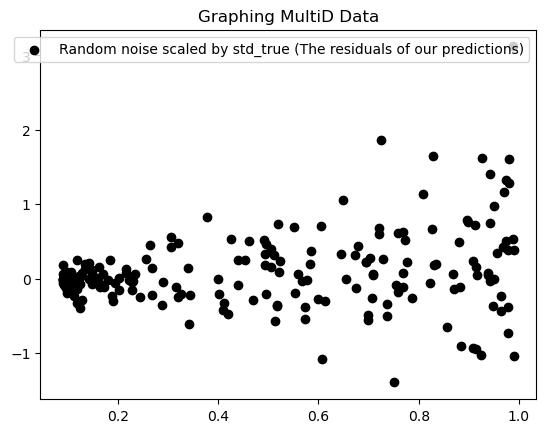

In [6]:
plt.figure()

#plt.scatter(x[0], y, color = 'blue', label = 'Base Nonlinear function')
#plt.scatter(x[0], t_true, color = 'red', label = 'True value curve (Represents our predictions)')
#plt.scatter(x[0], std_true, color = 'green', label = 'True Standard Deviation (True sigma)')
plt.scatter(std_true, d, color = 'black', label = 'Random noise scaled by std_true (The residuals of our predictions)')

plt.legend()
plt.title('Graphing MultiD Data')
plt.show()

# Model Definition

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()

        self.fc1 = nn.Linear(in_features=input_dim, out_features=20)  # Input layer to hidden layer 1
        self.fc2 = nn.Linear(in_features=20, out_features=5)  # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(in_features=5, out_features=1)   # Hidden layer 2 to output layer

        # Activation functions
        self.activation1 = nn.Tanh()  # satlins (symmetric saturating linear transfer function) is similar to tanh
        self.activation2 = nn.Identity()  # purelin (linear transfer function) is equivalent to no activation

        #nn.init.xavier_normal(self.fc1.weight, gain=1.0)
        #nn.init.xavier_normal(self.fc2.weight, gain=1.0)


    def forward(self, x):

        x = self.activation1(self.fc1(x))
        x = self.activation1(self.fc2(x))
        x = self.activation2(self.fc3(x))

        return x

In [94]:
class TestNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        #self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(128, 64)
        #self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(64, 1)

        #self.dropout = nn.Dropout(0.1)
        self.activation = nn.LeakyReLU(0.1)  # or nn.LeakyReLU(0.1)
        #self.softplus = nn.Softplus()

        # Initialize weights
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.activation(self.fc1(x))
        #x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)  # Identity for regression
        #x = self.softplus(x)

        return x

# Custom Cost Function

### CRPS_min and RS_min Calculation

In [9]:
import torch
import math

def est_beta(d):

    sigma_baseline = torch.std(d).detach()
    
    sqrt_2 = torch.sqrt(torch.tensor(2.0))
    sqrt_pi = torch.sqrt(torch.tensor(math.pi))
    sqrt_2_over_pi = torch.sqrt(torch.tensor(2.0 / math.pi))
    one = torch.tensor(1.0)
    
    x = (d / sigma_baseline) / sqrt_2
    erf_x = torch.erf(x)
    exp_neg_x2 = torch.exp(-x**2)
    CRPS = sigma_baseline * (
        sqrt_2 * x * erf_x 
        + sqrt_2_over_pi * exp_neg_x2 
        - one / sqrt_pi
    )
    CRPS_min = torch.mean(CRPS).item()
    
    N = d.size(0)
    sorted_indices = torch.argsort(x)
    orig_rank = torch.argsort(sorted_indices) + 1  # 1-based ranking
    orig_rank = orig_rank.float()
    
    term1 = (x / N) * (erf_x + one)
    term2 = x * (2.0 * orig_rank - one) / (N ** 2)
    term3 = exp_neg_x2 / (sqrt_pi * N)
    RS = N * (term1 - term2 + term3)
    RS_min = torch.mean(RS).item()
    
    beta = RS_min / (CRPS_min + RS_min) # Scale_CRPS
    
    return beta, CRPS_min, RS_min

beta, CRPS_min, RS_min = est_beta(d)

In [57]:
def est_beta(d):

    N = d.shape[0]
    #i = np.arange(1, N+1)
    # RS_min_1 = 1/(np.sqrt(np.pi)*N)
    # Convert to PyTorch and add clamping
    quantiles = (2*torch.arange(1,N+1).float()-1)/N - 1
    quantiles = quantiles.clamp(min=-0.99, max=0.99)  # Prevent extreme values

    RS_min_2 = -1*torch.erfinv(quantiles)**2
    RS_min = torch.exp(RS_min_2).sum()/(torch.sqrt(torch.tensor(math.pi))*N)
    # CRPS from matlab code
    sigma = np.abs(d)/np.sqrt(np.log(2))+1e-6
    dum = d/sigma/np.sqrt(2)
    CRPS_min = np.nanmean(sigma*(np.sqrt(2)*dum*erf(dum)
                            + np.sqrt(2/np.pi)*np.exp(-1*dum**2) 
                            - 1/np.sqrt(np.pi)))
    CRPS_min = torch.tensor(CRPS_min)
    
    return RS_min/(RS_min+CRPS_min), CRPS_min, RS_min

### Custom Cost Function Definition

In [93]:
class CustomLoss(nn.Module):
    def __init__(self, CRPS_min, RS_min):
        super(CustomLoss, self).__init__()
        self.CRPS_min = CRPS_min
        self.RS_min = RS_min

        self.sqrt_2 = torch.sqrt(torch.tensor(2.0))
        self.sqrt_pi = torch.sqrt(torch.tensor(math.pi))
        self.sqrt_2_over_pi = torch.sqrt(torch.tensor(2.0 / torch.pi))
        self.one = torch.tensor(1.0)


    def forward(self, d: torch.Tensor, curr: torch.Tensor, N: int):
      
      sigma = torch.exp(curr).squeeze() 

      x = (d / sigma) / self.sqrt_2

      erf_x = torch.erf(x)
      exp_neg_x2 = torch.exp(-x**2)

      ind = torch.argsort(x)
      ind_orig = torch.argsort(ind)+1
      #ind_orig = ind_orig.to(self.device)

      CRPS_1 = self.sqrt_2*x*torch.erf(x)
      CRPS_2 = self.sqrt_2_over_pi*torch.exp(-x**2) 
      CRPS_3 = torch.tensor(1)/self.sqrt_pi
      # CRPS_1 = CRPS_1.to(self.device)
      # CRPS_2 = CRPS_2.to(self.device)
                
      CRPS = sigma*(CRPS_1 + CRPS_2 - CRPS_3)

      # For each dimension k in [0, output_dim):

      term1 = (x / N) * (erf_x + self.one)
      term2 = x * (2.0 * ind_orig - self.one) / (N ** 2)
      term3 = exp_neg_x2 / (self.sqrt_pi * N)

      RS = N*(x/N*(torch.erf(x)+1) - x*(2*ind_orig-1)/N**2 + torch.exp(-x**2)/self.sqrt_pi/N)

      loss = (CRPS / self.CRPS_min) + (RS / self.RS_min)
      loss = torch.mean(loss)
        
      return loss + 1e-6

# Training Loop

### Training Setup

#### Goldberg Data Setup

In [150]:
input_dim = 1

# Training Set
N = 10000
x_tr, t_true_tr, nonlin_f_tr, d_tr, std_true_tr, y_tr = generate_data(N)

beta_tr, CRPS_min_tr, RS_min_tr = est_beta(d_tr)

x_tr = x_tr.view(-1,1).float()


## Validation Set
N = 5000
x_v, t_true_v, nonlin_f_v, d_v, std_true_v, y_v = generate_data(N)

beta_v, CRPS_min_v, RS_min_v = est_beta(d_v)


x_v = x_v.view(-1, 1).float()

#### MultiD Data Setup

In [171]:
input_dim = 5

# Training Set
N = 15000
D = input_dim

x_tr, t_true_tr, d_tr, std_true_tr = generate_multi_data(N, D)
d_tr = d_tr.squeeze()

beta_tr, CRPS_min_tr, RS_min_tr = est_beta(d_tr)

x_tr = x_tr.view(-1, input_dim)


# Validation Set
N = 5000
D = input_dim

x_v, t_true_v, d_v, std_true_v = generate_multi_data(N, D)
d_v = d_v.squeeze()

beta_v, CRPS_min_v, RS_min_v = est_beta(d_v)


x_v = x_v.view(-1, input_dim)

### Dumb Multivariate

In [78]:
# Generate synthetic data (5D input, 1D output)
N = 10000
D = 5

x_tr = torch.randn(N, D)
x_tr = x_tr.view(-1, input_dim)

std_true_tr = torch.tensor(0.1) + torch.abs(x_tr[:, 0])  # Ensure it's a PyTorch tensor
d_tr = torch.randn(N) * std_true_tr  # Avoid NumPy broadcasting issues

y_tr = torch.normal(0, std_true_tr)

# Generate synthetic data (5D input, 1D output)
N = 5000
D = 5

x_v = torch.randn(N, D)
x_v = x_v.view(-1, input_dim)

std_true_v = torch.tensor(0.1) + torch.abs(x_v[:, 0])  # Ensure it's a PyTorch tensor
d_v = torch.randn(N) * std_true_v  # Avoid NumPy broadcasting issues

y_v = torch.normal(0, std_true_v)

RuntimeError: normal expects all elements of std >= 0.0

In [355]:
d_tr.shape, x_tr.shape

(10000, torch.Size([10000, 5]))

### Training Loop

In [172]:
print(f"\nStarting Training Loop\n")

num_epochs = 500
# Network initialization af
model = TestNetwork(input_dim)


# Loss Functions
loss_fn_tr = CustomLoss(CRPS_min_tr, RS_min_tr)

tr_losses = []
v_losses = []
epoch_nums = []

# Optim
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=np.exp(-8))

for epoch in range(num_epochs):

    model.train()

    log_var_preds = model(x_tr)

    loss = loss_fn_tr(d_tr, log_var_preds, d_tr.shape[0])

    optimizer.zero_grad()
    loss.backward()

    

    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"Gradient Norm [{name}]:", param.grad.norm().item())

    optimizer.step()
    tr_losses.append(loss.item())
    epoch_nums.append(epoch)
    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}")


print(f"Final Training Loss: {loss.item():.6f}")


Starting Training Loop

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Gradient Norm [fc1.weight]: 0.08347256481647491
Gradient Norm [fc1.bias]: 0.07852417230606079
Gradient Norm [fc2.weight]: 0.4253416359424591
Gradient Norm [fc2.bias]: 0.08491268008947372
Gradient Norm [fc3.weight]: 0.7264886498451233
Gradient Norm [fc3.bias]: 0.257204532623291
Epoch 1, Training Loss: 2.356891632080078
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Gradient Norm [fc1.weight]: 14.874201774597168
Gradient Norm [fc1.bias]: 12.542551040649414
Gradient Norm [fc2.weight]: 41.90522766113281
Gradient Norm [fc

# Model Evaluation

In [173]:
model.eval()

preds_tr = model(x_tr) 
preds_tr = preds_tr.detach()

preds_v = model(x_v)
preds_v = preds_v.detach()

def exponentiate(x):
    return np.exp(x.detach().numpy())

### Univariate Graphing

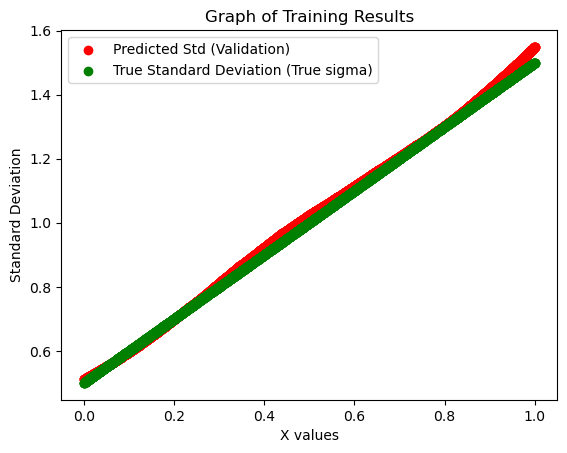

In [162]:
plt.figure()

#plt.scatter(x_tr, exponentiate(preds_tr), color = 'red', label = 'Predicted Std (Training)')
#plt.scatter(x_tr, std_true_tr, color = 'green', label = 'True Standard Deviation (True sigma)')

plt.scatter(x_v, exponentiate(preds_v), color = 'red', label = 'Predicted Std (Validation)')
plt.scatter(x_v, std_true_v, color = 'green', label = 'True Standard Deviation (True sigma)')

plt.xlabel("X values")
plt.ylabel("Standard Deviation")

plt.legend()
plt.title('Graph of Training Results')
plt.show()

### Plotting Confidence Bands (Univariate Only)

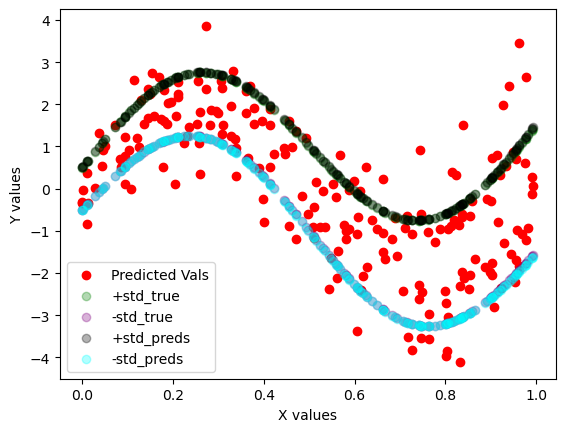

In [163]:
#ci_tr = 1.96 * std_true_tr/np.sqrt(len(xa))
#ci_pred = 1.96 * exponentiate(preds_tr)/np.sqrt(xa)

xa = x_tr.squeeze()
std_preds = exponentiate(preds_tr.squeeze())

plt.figure()

#plt.scatter(xa[0:200], y_tr[0:200], color = 'blue', label="")
plt.scatter(xa[0:200], t_true_tr[0:200], color = 'red', label="Predicted Vals")

#plt.scatter(xa, y_tr+std_true_tr)
#plt.scatter(xa, y_tr-std_true_tr)

#plt.fill_between(xa, y_tr+ci_tr, y_tr-ci_tr)

plt.scatter(xa[0:200], (y_tr+std_true_tr)[0:200], color = 'green', alpha = 0.3, label="+std_true")
plt.scatter(xa[0:200], (y_tr-std_true_tr)[0:200], color = 'purple', alpha=0.3, label="-std_true")

plt.scatter(xa[0:200], (y_tr+std_preds)[0:200], color = 'k', alpha = 0.3, label="+std_preds")
plt.scatter(xa[0:200], (y_tr-std_preds)[0:200], color = 'aqua', alpha=0.3, label="-std_preds")


plt.legend()
plt.xlabel("X values")
plt.ylabel("Y values")

plt.show()

### 2D Histogram of Predicted Standard Deviation vs. True

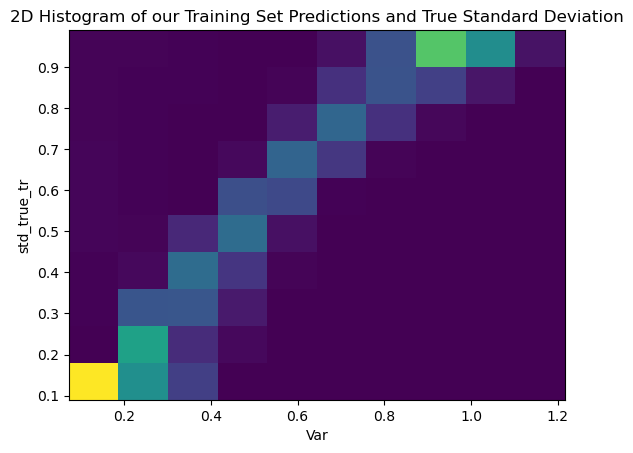

In [174]:
var = exponentiate(preds_tr.squeeze())

plt.figure()

plt.hist2d(x = var, y = std_true_tr, range=[[min(var), max(var)], [min(std_true_tr), max(std_true_tr)]])

plt.xlabel("Var")
plt.ylabel("std_true_tr")
plt.title("2D Histogram of our Training Set Predictions and True Standard Deviation")
#plt.legend()

plt.show()

### Predictions vs. True Std. Deviation

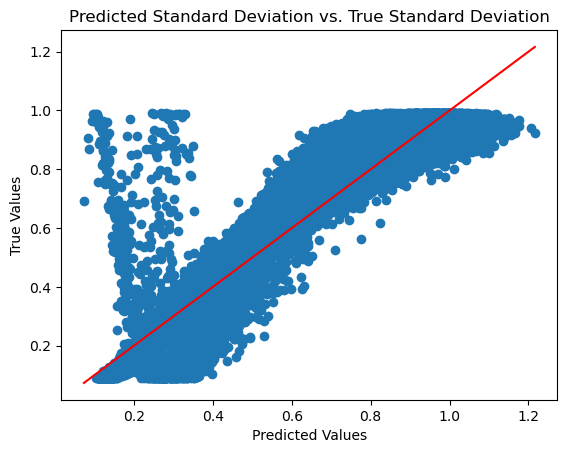

In [175]:
x = exponentiate(preds_tr)
y = std_true_tr
plt.figure()

plt.scatter(x, y, label = "Predicted vs. True")
plt.plot([min(x), max(x)], [min(x), max(x)], color='red', label='Diagonal Line', alpha=1)

plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.title("Predicted Standard Deviation vs. True Standard Deviation")
plt.show()

### Residual Graphing

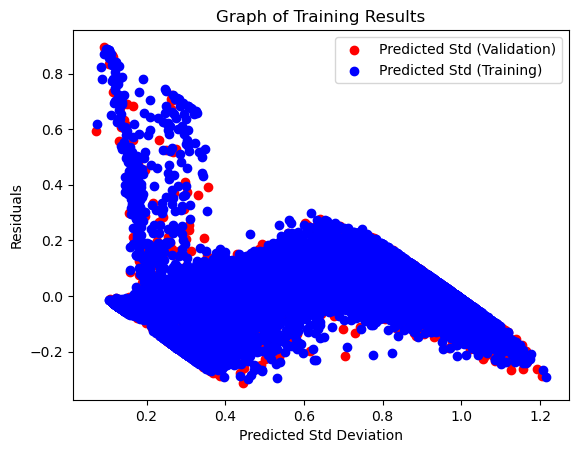

In [176]:
preds_v = preds_v.squeeze()
preds_tr = preds_tr.squeeze()

residuals_v = std_true_v - exponentiate(preds_v)
residuals_tr = std_true_tr - exponentiate(preds_tr)

residuals_v_sqr = (std_true_v - exponentiate(preds_v))**2
residuals_tr_sqr = (std_true_tr - exponentiate(preds_tr))**2

residuals_v_n = std_true_v - preds_v.detach()
residuals_tr_n = std_true_tr - preds_tr.detach()

standardized_tr = residuals_tr.numpy() / np.std(residuals_tr.numpy())
standardized_v = residuals_v.numpy() / np.std(residuals_v.numpy())

plt.figure()

plt.scatter(exponentiate(preds_v.detach()), residuals_v, color = 'red', label = 'Predicted Std (Validation)')
#plt.scatter(preds_v.detach(), standardized_v, color = 'red', label = 'Predicted Std (Validation)')
#plt.scatter(preds_v.detach(), residuals_v_sqr, color = 'red', label = 'Predicted Std (Validation)')
#plt.scatter(preds_v.detach(), residuals_v_n, color = 'red', label = 'Predicted Std (Validation)')

plt.scatter(exponentiate(preds_tr.detach()), residuals_tr, color = 'blue', label = 'Predicted Std (Training)')
#plt.scatter(preds_tr.detach(), residuals_v, color = 'blue', label = 'Predicted Std (Training)')
#plt.scatter(preds_tr.detach(), residuals_tr_sqr, color = 'blue', label = 'Predicted Std (Training)')
#plt.scatter(preds_tr.detach(), residuals_tr_n, color = 'blue', label = 'Predicted Std (Training)')


plt.xlabel("Predicted Std Deviation")
plt.ylabel("Residuals")

plt.legend()
plt.title('Graph of Training Results')
plt.show() 

### Performance Statistics

In [177]:
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(std_true_v, exponentiate(preds_v.detach()))
mse = mean_squared_error(std_true_v, exponentiate(preds_v))
rmse = np.sqrt(mean_squared_error(std_true_v, exponentiate(preds_v)))
mape = mean_absolute_percentage_error(std_true_v, exponentiate(preds_v))*100

print(f"Mean Absolute Error (Validation): {mae:.4}")
print(f"Mean Squared Error (Validation): {mse:.4}")
print(f"Root Mean Squared Error (Validation): {rmse:.4}")
print(f"Mean Absolute Percentage Error (Validation): {mape:.4}%")



Mean Absolute Error (Validation): 0.07104
Mean Squared Error (Validation): 0.01074
Root Mean Squared Error (Validation): 0.1036
Mean Absolute Percentage Error (Validation): 23.06%


### Histogram of Predicted Std. vs. True

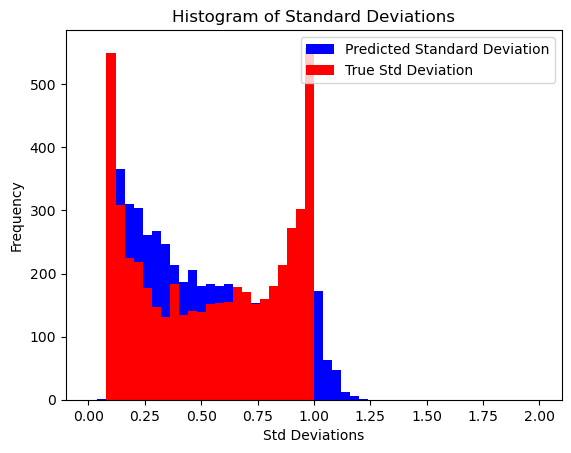

In [178]:
plt.figure()

#plt.hist(std_true_tr.detach(), color = "red", label = "True Std Deviation")
_, bins, _ = plt.hist(std_true_v, bins=50, range=[0, 2], density=True)

plt.hist(exponentiate(preds_v), color = 'blue', label = "Predicted Standard Deviation", bins = bins)
plt.hist(std_true_v, color = "red", label = "True Std Deviation", bins = bins)


plt.title("Histogram of Standard Deviations")

plt.xlabel("Std Deviations")
plt.ylabel("Frequency")

plt.legend() 

plt.show()

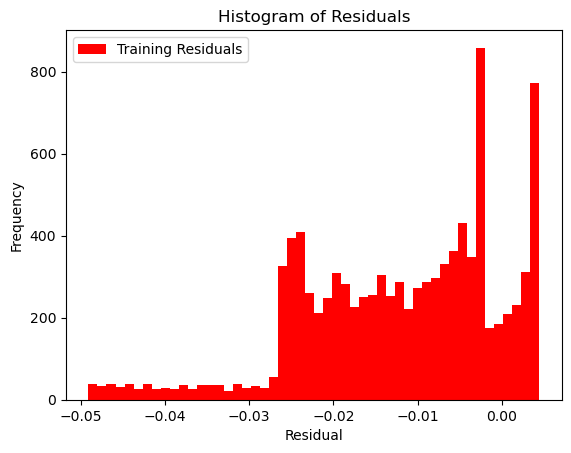

In [169]:
plt.figure()

plt.hist(residuals_tr.detach(), color = "red", label = "Training Residuals", bins = 50)
#plt.hist(residuals_v.detach(), color = 'blue', label = "Validation Residuals")

plt.title("Histogram of Residuals")

plt.xlabel("Residual")
plt.ylabel("Frequency")

plt.legend() 

plt.show()

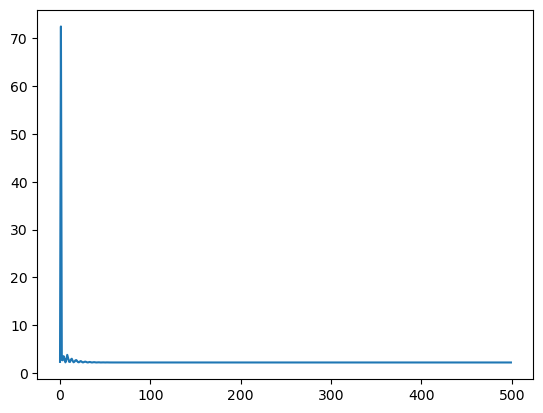

In [170]:
plt.figure()

plt.plot(tr_losses)

plt.show()